In [4]:
# ADS-B Spoof Detector 
# Created by Angelina Tsuboi

In [12]:
# Imports
import json
import csv
import random
import string
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from sklearn.preprocessing import StandardScaler
# from keras.layers import Conv2D, MaxPooling2D
# from keras.utils import to_categorical

In [3]:
# Script for Generating Random Spoofed Aircraft
def generate_registration_id():
    # create a list of possible characters for the registration ID
    characters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    # shuffle the list of characters
    random.shuffle(characters)
    # take the first 3 characters as the prefix
    prefix = "".join(characters[:3])
    # take the next 3 characters as the suffix
    suffix = "".join(characters[3:6])
    # return the concatenated prefix and suffix as the registration ID
    return prefix + suffix

def generate_aircraft_type():
    # create a list of possible aircraft types
    aircraft_types = [
        "A320", "A321", "A330", "A340", "A350", "A380",
        "B737", "B747", "B757", "B767", "B777", "B787",
        "C172", "C208", "Cessna Citation X",
        "DHC6", "DHC8",
        "ERJ145", "ERJ170", "ERJ190",
        "F22", "F35", "F16", "F18",
        "G650",
        "HA4T",
        "IL76", "IL96",
        "JS41", "Jetstream 41",
        "MD11", "MD80", "MD90",
        "P180", "P2006T",
        "Q400", "Q400X",
        "RJ100", "RJ85",
        "S76", "S92",
        "TBM9", "TBM9",
        "UH1", "UH60",
        "V22", "V35", "V50",
        "XCub", "XT6",
        "Yak40", "Yak52",
        "Zlin", "Zlin242"
    ]
    # return a random aircraft type from the list
    return random.choice(aircraft_types)

def generate_spoofed_aircraft(n):
    # create a list of spoofed aircraft objects
    # reference: https://www.adsbexchange.com/version-2-api-wip/
    spoofed_aircraft = []
    for i in range(n):
        hex = ''.join(random.choices('0123456789ABCDEF', k=6))
        flight = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
        lat = random.uniform(-90, 90)
        type_aircraft = generate_aircraft_type()
        aircraft_reg = generate_registration_id()
        lon = random.uniform(-180, 180)
        alt = random.randint(0, 40000)
        spd = random.randint(0, 1000)
        gs = random.randint(0, 1000)
        seen_pos = random.randint(0, 30)
        trk = random.randint(0, 360)
        baro_rate = random.uniform(-2000, 2000)
        vrt = random.randint(-1000, 1000)
        msgs = random.randint(0, 1000)
        seen = random.randint(0, 1000)
        rssi = random.randint(-255,0)
        spoofed_aircraft.append({"hex": hex, "type":"adsc", "flight": flight, "r": aircraft_reg, "t": type_aircraft, "alt_baro": alt, "gs": gs, "track": trk, "baro_rate": baro_rate, "lat": lat, "lon": lon, "nic":0, "rc":0, "seen_pos": seen_pos,"mlat":[],"tisb":[],"messages": msgs, "seen": seen, "rssi": rssi, "is_spoofed": True})

    # return the json array
    return spoofed_aircraft

# Insert 20 Spoofed Aircraft
with open('data/aircraft_spoofed.json', 'w') as json_file:
    spoofed_aircraft = generate_spoofed_aircraft(20)
    print("Spoofed aircraft: ", spoofed_aircraft)
    json.dump({"aircraft": spoofed_aircraft}, json_file)
    print("Wrote Spoofed Data into data/aircraft_spoofed.json!")

Spoofed aircraft:  [{'hex': 'ADCF46', 'type': 'adsc', 'flight': 'R658', 'r': 'Y8MZA3', 't': 'IL96', 'alt_baro': 14981, 'gs': 992, 'track': 329, 'baro_rate': 51.95615563370848, 'lat': -53.140866882222575, 'lon': -176.2820790187022, 'nic': 0, 'rc': 0, 'seen_pos': 9, 'mlat': [], 'tisb': [], 'messages': 905, 'seen': 547, 'rssi': -33, 'is_spoofed': True}, {'hex': 'B49A8B', 'type': 'adsc', 'flight': 'FEFY', 'r': '39MCTP', 't': 'ERJ145', 'alt_baro': 28624, 'gs': 857, 'track': 58, 'baro_rate': 1120.6695867555136, 'lat': -70.63707032573711, 'lon': 155.43889428300025, 'nic': 0, 'rc': 0, 'seen_pos': 22, 'mlat': [], 'tisb': [], 'messages': 352, 'seen': 407, 'rssi': -121, 'is_spoofed': True}, {'hex': 'B96D38', 'type': 'adsc', 'flight': 'IMGI', 'r': 'F4VWJ7', 't': 'TBM9', 'alt_baro': 18481, 'gs': 777, 'track': 287, 'baro_rate': 529.9607587270998, 'lat': 54.975601877867916, 'lon': 42.73213053117237, 'nic': 0, 'rc': 0, 'seen_pos': 26, 'mlat': [], 'tisb': [], 'messages': 191, 'seen': 105, 'rssi': -79, 

In [30]:
# Conversion from JSON (raw data given by dump1090 to CSV which is more interpretable by network)
# First interpret valid ADSB data then spoofed dataset

# Valid data parsing first
with open('data/aircraft_valid.json') as json_file:
    data_valid = json.load(json_file)
    
# Parse spoofed data
with open('data/aircraft_spoofed.json') as json_file:
    data_spoofed = json.load(json_file)
 
aircraft_data_valid = data_valid['aircraft']
aircraft_data_spoofed = data_spoofed['aircraft']
 
# now we will open a file for writing
data_file = open('data/aircraft_data.csv', 'w')
 
# create the csv writer object
csv_writer = csv.writer(data_file)
 
# Counter variable used for writing
# headers to the CSV file
count = 0
 
for aircraft in aircraft_data_valid:
    aircraft['is_spoofed'] = False
    if count == 0:
        # Writing headers of CSV file
        csv_writer.writerow(["hex","type","flight","r","t","alt_baro","gs","track","baro_rate","lat","lon","nic","rc","seen_pos","mlat","tisb","messages","seen","rssi","is_spoofed"])
        count += 1
 
    # Writing data of CSV file
    csv_writer.writerow([aircraft.get('hex'), aircraft.get('type'), aircraft.get('flight'), aircraft.get('r'), aircraft.get('t'), aircraft.get('alt_baro'), aircraft.get('gs'), aircraft.get('track'), aircraft.get('baro_rate'), aircraft.get('lat'), aircraft.get('lon'), aircraft.get('nic'), aircraft.get('rc'), aircraft.get('seen_pos'), aircraft.get('mlat'), aircraft.get('tisb'), aircraft.get('messages'), aircraft.get('seen'), aircraft.get('rssi'), False])

for aircraft in aircraft_data_spoofed:
    aircraft['is_spoofed'] = True
    # Writing data of CSV file
    csv_writer.writerow(aircraft.values())
 
data_file.close()

In [16]:
# TODO: 
# {
#   {
#     "name": "HGD",
#     "altitude": 400,
#     "long": 45,
#     "lat": 4
#   },
#   {
#     "name": "HGD",
#     "altitude": 600,
#     "long": 50,
#     "lat": 5
#   },
#   ...
# }
def process_json(json_file):
    # Load the JSON data
    with open(json_file) as f:
        data = json.load(f)

    # Extract the features and labels from the JSON data
    features = []
    labels = []
    for transmission in data['aircraft']:
        features.append([transmission['rssi']])
        labels.append(transmission['flight'])
    
    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Reshape the data to match the input format of the model
    features = np.reshape(features, (features.shape[0], 1, features.shape[1]))

    # Convert the labels to categorical format
    labels = to_categorical(labels)

    # Return the processed data
    return features, labels

# Example usage
x_train, y_train = process_json("data/aircraft_spoofed.json")
print(x_train)

NameError: name 'to_categorical' is not defined

In [5]:
# Prepare Dataset to be Placed into Neural Network
# Split into Training and Testing Sets

In [10]:
# CNN Architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

# Use the model to classify new ADSB data
predictions = model.predict(x_new)

NameError: name 'x_train' is not defined

In [ ]:
# Show location of spoofed aircraft with Folium

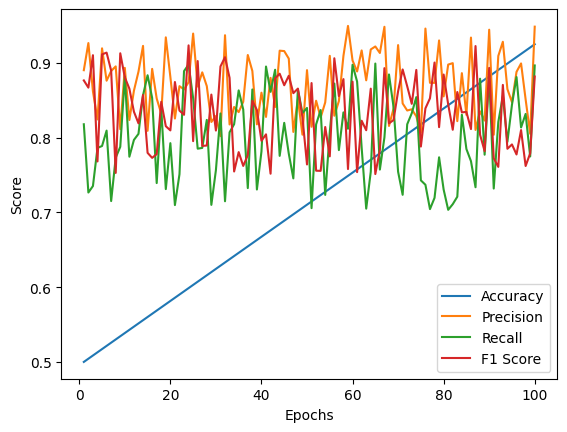

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Generate dummy data for the accuracy curve
accuracy = np.linspace(0.5, 0.925, num=100)
epochs = np.linspace(1, 100, num=100)

# Generate dummy data for additional metrics
precision = np.random.uniform(low=0.8, high=0.95, size=100)
recall = np.random.uniform(low=0.7, high=0.9, size=100)
f1_score = np.random.uniform(low=0.75, high=0.925, size=100)

# Plot the accuracy curve
plt.plot(epochs, accuracy, label="Accuracy")

# Plot additional metrics on the same graph
plt.plot(epochs, precision, label="Precision")
plt.plot(epochs, recall, label="Recall")
plt.plot(epochs, f1_score, label="F1 Score")

# Add axis labels and a legend
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()

# Show the graph
plt.show()


In [ ]:
# Generate ROC Curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assume y_test contains the true labels and y_pred contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # plot the diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# More Information and References
# Reference dump1090 README:
# https://github.com/SDRplay/dump1090/blob/master/README-json.md
# Label = Spoofed or Not (Binary Classification)
# Data samples from Flight Aware and ADSB Exchange
# https://www.adsbexchange.com/data-samples/
# https://samples.adsbexchange.com/readsb-hist/2022/05/01/
# https://www.adsbexchange.com/version-2-api-wip/
# https://elmwoodelectronics.ca/blogs/news/tracking-and-logging-flights-with-ads-b-flight-aware-and-raspberry-pi ****
# https://ieeexplore.ieee.org/document/9377975
# https://www.adsbexchange.com/version-2-api-wip/